# Emotion detector avec Keras et fer2013

Le but de ce notebook est de developper un réseau de neurones capable de détécter les émotions.

Pour cela on utilisera la librairie Keras et le dataset `fer2013`.

## *Import des librairies :*

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import keras
import cv2

from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.applications import VGG16

from livelossplot import PlotLossesKerasTF
from sklearn.metrics import confusion_matrix

## *Import du jeu de données :*

In [3]:
df = pd.read_csv('data/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## *Data cleaning :*

In [4]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

On remarque que le dataset est déjà partitionné en train, validation et test.

On va créer 3 sous dataframes :

In [5]:
df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PrivateTest']
df_test = df[df['Usage'] == 'PublicTest']
print(df_train.shape, df_val.shape, df_test.shape)

(28709, 3) (3589, 3) (3589, 3)


Le but désormais est d'implémenter une fonction qui va :
- Modifier la colonne `pixels` qui est pour l'instant des chaînes de caractères en listes d'entiers
- Reshape et normaliser (niveaux de gris) chaque array
- Encoder les sorties (one-hot encoding)
- Split le jeu de données

In [6]:
num_classes = 7
height, width = 48, 48
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']

def CRNO(df, dataName):
    """CRNO stands for Convert, Reshape, Normalize, One-hot encoding
    (i) convert strings to lists of integers
    (ii) reshape and normalise grayscale image with 255.0
    (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]"""
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

    
X_train, y_train = CRNO(df_train, "train") #training data
X_val, y_val = CRNO(df_val, "val") #validation data
X_test, y_test = CRNO(df_test, "test") #test data

train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


## *DeepLearning :*

### Création du CNN

In [7]:
# Initialising the CNN
model = Sequential()

# 1st - Convolution Layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Flattening
model.add(Flatten())

# Fully connected layer : 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Fully connected layer : 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### Data augmentation

In [8]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow(X_train, y_train,
                                    batch_size=batch_size,
                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow(X_val, y_val,
                                                batch_size=batch_size)

### Entrainement du modèle

On utilise un `EarlyStopping` basé sur la `val_loss` pour éviter l'overfitting du modèle.

Cela va nous permettre d'arrêter son entraînement dès qu'il n'y aura pas d'amélioration de cette métrique durant 10 epochs

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [9]:
epochs = 100
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Training the Model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data = validation_generator,
#     validation_steps = validation_steps,
#     callbacks=[PlotLossesKerasTF(), early_stopping]
# )

In [10]:
#RECUPERATION DU MODELE ENTRAINE VIA GOOGLE COLAB POUR UTILISATION DU GPU
model_v1 = keras.models.load_model('models/model_v1.h5')

### Score du modèle

In [11]:
test_loss, test_acc = model_v1.evaluate(X_test, y_test)
print('Test accuracy:', round(test_acc,4))

113/113 [==============================] - 27s 229ms/step - loss: 2.4367 - accuracy: 0.6252
Test accuracy: 0.6252


### Matrice de confusion

In [12]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')

113/113 [==============================] - 31s 273ms/step


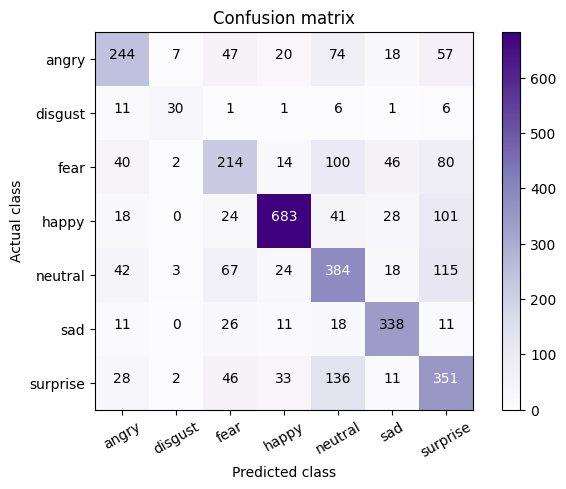

In [24]:
# Predict the values from the validation dataset
Y_pred = model_v1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)

### Prédictions

In [14]:
def show_image(image):
    """Plot une image qui est sous forme d'array"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

In [15]:
def prediction(image, model):
    """Réalise une prédiction d'émotion sur une image sous forme d'un array 
    de dimensions (48,48,1)"""
    class_names = {
    0 : 'angry',
    1 : 'disgust',
    2 : 'fear',
    3 : 'happy',
    4 : 'neutral',
    5 : 'sad',
    6 : 'surprise'
    }
    image = tf.expand_dims(image, 0)
    return class_names[np.argmax(model.predict(image))]

1/1 [==============================] - 0s 60ms/step


'happy'

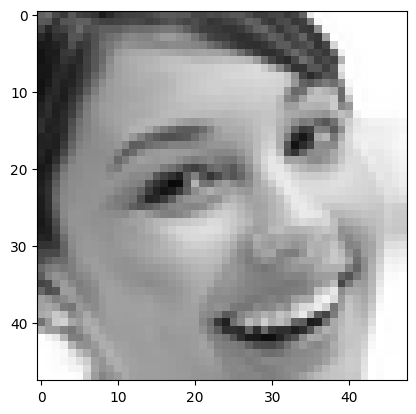

In [38]:
index = np.random.randint(1, 3589)
show_image(X_test[index])
prediction(X_test[index], model_v1)

Le but désormais est d'utiliser ce modèle dans notre script `emotions.py` qui a pour but de détécter l'émotion d'un visage capturé à l'aide de la webcam de l'ordinateur.

# *Tranfer learning :*

On va utiliser le modèle VGG16 qui est pré-entraîné avec des images en 3 dimensions.

On doit donc modifier notre jeu de données pour qu'il soit adapté :

In [17]:
X_train_rgb = np.tile(X_train, (1, 1, 1, 3))
X_val_rgb = np.tile(X_val, (1, 1, 1, 3))
X_test_rgb = np.tile(X_test, (1, 1, 1, 3))

In [18]:
print(X_train.shape, X_train_rgb.shape)

(28709, 48, 48, 1) (28709, 48, 48, 3)


In [39]:
# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, 
                    input_shape=(48, 48, 3))

# Ajout des couches de classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Création du modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Dégeler les couches de convolution pour le fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compilation du modèle
model.compile(optimizer=opt, loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Entraînement du modèle avec des données spécifiques
# model.fit(X_train_rgb, y_train, batch_size=32, epochs=10, 
#             validation_data=(X_val_rgb, y_val))

In [20]:
#LE MODELE A ETE ENTRAINE VIA GPU GOOGLE COLAB
model_v2 = keras.models.load_model('models/model_v2.h5')

*Score :*

In [21]:
test_loss2, test_acc2 = model_v2.evaluate(X_test_rgb, y_test)
print('Test accuracy:', round(test_acc2, 4))

113/113 [==============================] - 53s 468ms/step - loss: 1.5537 - accuracy: 0.6406
Test accuracy: 0.6406


*Matrice de confusion :*

113/113 [==============================] - 51s 447ms/step


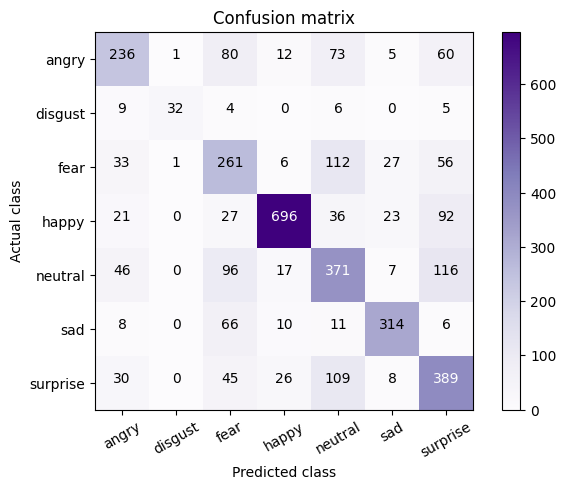

In [23]:
# Predict the values from the validation dataset
Y_pred2 = model_v2.predict(X_test_rgb)
# Convert predictions classes to one hot vectors 
Y_pred_classes2 = np.argmax(Y_pred2, axis = 1) 
# Convert validation observations to one hot vectors
Y_true2 = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx2 = confusion_matrix(Y_true2, Y_pred_classes2) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx2, classes = class_names)